In [101]:
import pyodbc
import pandas as pd
import time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

pw_file = open("/home/bkb12/pw.txt", "r") 
pw = pw_file.read().strip('\n')

connection_string = ("Driver={ODBC Driver 17 for SQL Server};" + 
                     "server=cbmiwsqld02.med.harvard.edu;" +
                     "domain=CBMIWSQLD02"
                     "database=AetnaDataWarehouse;" +
                     "uid=bkb12_sql;" +
                     "pwd=" + pw + ";" +
                     "ssl=require;")

cn = pyodbc.connect(connection_string, autocommit=True)
cursor = cn.cursor()

D8m1201eight
Driver={ODBC Driver 17 for SQL Server};server=cbmiwsqld02.med.harvard.edu;domain=CBMIWSQLD02database=AetnaDataWarehouse;uid=bkb12_sql;pwd=D8m1201eight;ssl=require;


### All PD ICD Diagnoses

In [102]:
cursor.execute("IF OBJECT_ID('tempdb.dbo.#tmp_pd', 'U') IS NOT NULL DROP TABLE #tmp_pd;")
cursor.execute("SELECT MemberNum, FirstDate INTO #tmp_pd FROM gmw3.dbo.DistinctDiagnosis " +
               "WHERE DiagnosisCode = '332.0' AND PresentOnAdmission is NULL;")
cases = cursor.execute("SELECT COUNT(1) FROM #tmp_pd").fetchone()
print(cases)

(91623, )


### Plot distribution of member facts after PD diagnosis (of patients with 2 years quiescence beforehand)

In [51]:
query = ("SELECT MemberNum, StartDate FROM gmw3.dbo.ObservationDiagnosis WHERE DiagnosisCode = '332.0' " +
         "AND MemberNum IN (SELECT MemberNum FROM bkb12.dbo.pd_Enrollment " +
         #"WHERE (MedicalIndicator = 'Y') AND (DATEDIFF(D, EffectiveDate, First_PD) > 1095)) " +
         "WHERE (MedicalIndicator = 'Y') AND (DATEDIFF(D, EffectiveDate, First_PD) > 730)) " +
         "ORDER BY MemberNum, StartDate ASC;")
df = pd.read_sql_query(query, cn)
print(df.shape)

(262938, 2)


In [52]:
print(df.head())
print(len(df['MemberNum'].unique()))

    MemberNum   StartDate
0  1585508525  2010-10-26
1  2339300925  2011-09-14
2  2504100525  2011-01-26
3  2504100525  2012-01-22
4  2585508525  2010-03-02
27601


In [46]:
diff_list = []

mem_num = None
PrevDate = None

for i, row in df.iterrows():
    if row['MemberNum'] == mem_num:
        diff_list.append((row['StartDate'] - PrevDate).days)
    else:
        mem_num = row['MemberNum']
        PrevDate = row['StartDate']

In [47]:
diff_dict = {}

mem_num = None
PrevDate = None

for i, row in df.iterrows():
    if row['MemberNum'] in diff_dict.keys():
        continue
    elif row['MemberNum'] == mem_num:
        diff_dict[row['MemberNum']] = (row['StartDate'] - PrevDate).days
    else:
        mem_num = row['MemberNum']
        PrevDate = row['StartDate']

0.0
0.0
0.0
0.0
0.0
0.0
1.0
4.0
7.0
10.0
15.0
21.0
28.0
33.0
42.0
55.0
72.0
98.0
150.10000000000036
277.0


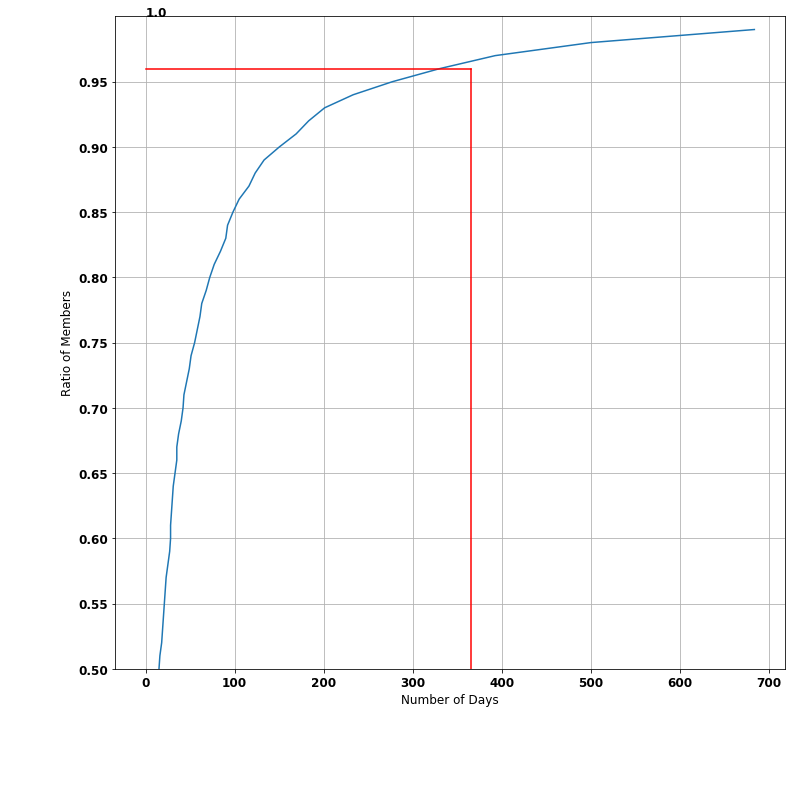

In [48]:
dd = pd.Series(diff_dict)

quants = dd.quantile([i * 0.01 for i in range(100)])
# print(quants)

f = plt.figure(figsize=(12,12))

plt.plot(quants, quants.index)
ax = plt.gca()


i = 0
for y in quants:
    if i % 5 == 0:
        print(y)
        ax.annotate('%s' % y, xy=(i*0.01, y), textcoords='data')
    if i > 95:
        ax.annotate('%s' % y, xy=(i*0.01, y), textcoords='data')
    i += 1
plt.grid()

plt.ylim([0.5, 1])
plt.yticks([0.05 * i for i in range(10,20)])
plt.xlabel('Number of Days')
plt.ylabel('Ratio of Members')
plt.plot([0, 365], [0.96, 0.96], color="red")
plt.plot([365, 365], [0, 0.96], color="red")

In [19]:
dd.describe()

count    19932.000000
mean        65.813315
std        156.880693
min          0.000000
25%          0.000000
50%         16.000000
75%         59.000000
max       4316.000000
dtype: float64

235337


(array([1.03227e+05, 4.66630e+04, 3.34140e+04, 2.37420e+04, 1.54650e+04,
        8.49000e+03, 3.74000e+03, 4.40000e+02, 6.00000e+00, 2.00000e+00,
        1.80000e+01, 1.10000e+01, 4.20000e+01, 4.20000e+01, 1.20000e+01,
        1.40000e+01, 1.00000e+00, 2.00000e+00, 2.00000e+00, 4.00000e+00]),
 array([   0.  ,  280.85,  561.7 ,  842.55, 1123.4 , 1404.25, 1685.1 ,
        1965.95, 2246.8 , 2527.65, 2808.5 , 3089.35, 3370.2 , 3651.05,
        3931.9 , 4212.75, 4493.6 , 4774.45, 5055.3 , 5336.15, 5617.  ]),
 <a list of 20 Patch objects>)

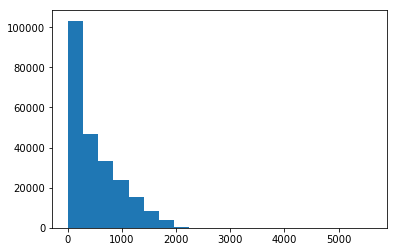

In [20]:
print(len(diff_list))
dl = pd.Series(diff_list)
plt.hist(diff_list, bins=20)

### PD Cases with coverage + Dysk Status

In [21]:
cursor.execute("IF OBJECT_ID('bkb12.dbo.pd_dysk', 'U') IS NOT NULL " +
               "DROP TABLE bkb12.dbo.pd_dysk;")
query = ("SELECT pd.MemberNum, pd.FirstDate PDdate, dys.FirstDys DYSdate, " +  
        "datediff(d, pd.FirstDate, dys.FirstDys) as PDtoDys, e.LastCancel, " + 
        "datediff(d, e.CoverageStart, pd.FirstDate) as CoverageToPD, " +
        "IIF(e.LastCancel < Cast('02/29/2016' as datetime), " + 
        "datediff(d, pd.FirstDate, e.LastCancel), " + 
        "datediff(d, pd.FirstDate, Cast('02/29/2016' as datetime))) as PDtoNow, " +
        "ldopa.FirstDate as FirstLdopa, pram.FirstDate as FirstPram, " +
        "rop.FirstDate as FirstRop, rot.FirstDate as FirstRot, " + 
        "ldopa.ldopa_claims, pram.pram_claims, rop.rop_claims, rot.rot_claims, " + 
        "member.BirthYearMinus1900, member.Gender " + 
        "INTO bkb12.dbo.pd_dysk FROM (" + 
        "SELECT MemberNum, FirstDate from gmw3.dbo.DistinctDiagnosis " + 
        "WHERE DiagnosisCode = '332.0' AND " + 
        "PresentOnAdmission is NULL AND " + 
        "FirstDate > Cast('12/31/2008' as datetime)) pd " + 
        "LEFT JOIN (SELECT MemberNum, MIN(FirstDate) FirstDys " + 
        "FROM gmw3.dbo.DistinctDiagnosis " + 
        "WHERE DiagnosisCode IN ('333.85', '333.72', '332.1',  '333.82') " + 
        "AND PresentOnAdmission is NULL GROUP BY MemberNum ) dys " + 
        "ON pd.MemberNum = dys.MemberNum " +
        "LEFT JOIN (SELECT MemberNum, MIN(EffectiveDate) as CoverageStart, MAX(CancelDate) as LastCancel " + 
        "FROM bkb12.dbo.pd_Enrollment " + 
        "WHERE CancelDate is not Null AND MedicalIndicator = 'Y' " +
        "AND DrugIndicator = 'Y' GROUP BY MemberNum) e " + 
        "ON pd.MemberNum = e.MemberNum " + 
        "LEFT JOIN (SELECT MemberNum, SUM(NumberOfClaims) as ldopa_claims, " +
        "MIN(FirstDispenseDate) as FirstDate " + 
        "FROM gmw3.dbo.DistinctMedication dm " +
        "WHERE NationalDrugCode IN " +
        "(SELECT NationalDrugCode FROM bkb12.dbo.dc_ldopa) " +
        "GROUP BY MemberNum ) ldopa ON pd.MemberNum = ldopa.MemberNum " + 
        "LEFT JOIN ( SELECT MemberNum, " + 
        "SUM(NumberOfClaims) as pram_claims, MIN(FirstDispenseDate) as FirstDate " +
        "FROM gmw3.dbo.DistinctMedication dm WHERE NationalDrugCode IN " + 
        "(SELECT NationalDrugCode FROM bkb12.dbo.dc_pramipexole) " + 
        "GROUP BY MemberNum ) pram ON pd.MemberNum = pram.MemberNum " + 
        "LEFT JOIN (SELECT MemberNum, " + 
        "SUM(NumberOfClaims) as rop_claims, MIN(FirstDispenseDate) as FirstDate " +
        "FROM gmw3.dbo.DistinctMedication dm WHERE NationalDrugCode IN " + 
        "(SELECT NationalDrugCode FROM bkb12.dbo.dc_ropinirole) " + 
        "GROUP BY MemberNum ) rop ON pd.MemberNum = rop.MemberNum " +
        "LEFT JOIN (SELECT MemberNum, " + 
        "SUM(NumberOfClaims) as rot_claims, MIN(FirstDispenseDate) as FirstDate " + 
        "FROM gmw3.dbo.DistinctMedication dm WHERE NationalDrugCode IN " + 
        "(SELECT NationalDrugCode FROM bkb12.dbo.dc_rotigotine) " +
        "GROUP BY MemberNum ) rot ON pd.MemberNum = rot.MemberNum " +
        "LEFT JOIN gmw3.dbo.Member as member " +
        "ON member.MemberNum = pd.MemberNum " +
        "WHERE (datediff(d, pd.FirstDate, dys.FirstDys) > 0 OR dys.FirstDys is Null);")
print(query)
cursor.execute(query)

SELECT pd.MemberNum, pd.FirstDate PDdate, dys.FirstDys DYSdate, datediff(d, pd.FirstDate, dys.FirstDys) as PDtoDys, e.LastCancel, datediff(d, e.CoverageStart, pd.FirstDate) as CoverageToPD, IIF(e.LastCancel < Cast('02/29/2016' as datetime), datediff(d, pd.FirstDate, e.LastCancel), datediff(d, pd.FirstDate, Cast('02/29/2016' as datetime))) as PDtoNow, ldopa.FirstDate as FirstLdopa, pram.FirstDate as FirstPram, rop.FirstDate as FirstRop, rot.FirstDate as FirstRot, ldopa.ldopa_claims, pram.pram_claims, rop.rop_claims, rot.rot_claims, member.BirthYearMinus1900, member.Gender INTO bkb12.dbo.pd_dysk FROM (SELECT MemberNum, FirstDate from gmw3.dbo.DistinctDiagnosis WHERE DiagnosisCode = '332.0' AND PresentOnAdmission is NULL AND FirstDate > Cast('12/31/2008' as datetime)) pd LEFT JOIN (SELECT MemberNum, MIN(FirstDate) FirstDys FROM gmw3.dbo.DistinctDiagnosis WHERE DiagnosisCode IN ('333.85', '333.72', '332.1',  '333.82') AND PresentOnAdmission is NULL GROUP BY MemberNum ) dys ON pd.MemberNum 

In [22]:
query = ("SELECT AVG(PDtoNow) AvgDate, COUNT(ldopa_claims) LdopaClaims, " +
         "count(pram_claims) PramClaims, count(rop_claims) RopClaims, " +
         "count(rot_claims) RotClaims FROM bkb12.dbo.pd_dysk;")
print(query)
res = pd.read_sql_query(query, cn)
print(res)

SELECT AVG(PDtoNow) AvgDate, COUNT(ldopa_claims) LdopaClaims, count(pram_claims) PramClaims, count(rop_claims) RopClaims, count(rot_claims) RotClaims FROM bkb12.dbo.pd_dysk;
   AvgDate  LdopaClaims  PramClaims  RopClaims  RotClaims
0     1274        13754        1639       1849        724


In [59]:
# Separate into ldopa only, rop only, and combined
query = ("SELECT * FROM bkb12.dbo.pd_dysk")
print(query)
res = pd.read_sql_query(query, cn)
# res['ldopa_claims'].fillna(0, inplace=True)
# res['pram_claims'].fillna(0, inplace=True)
# res['rop_claims'].fillna(0, inplace=True)
# res['rot_claims'].fillna(0, inplace=True)

res.fillna(0, inplace=True)

print(res.shape)
print(res.head())
print(len(res['MemberNum'].unique()))

SELECT * FROM bkb12.dbo.pd_dysk
(61866, 17)
     MemberNum      PDdate     DYSdate  PDtoDys  LastCancel  CoverageToPD  \
0   4183588525  2010-10-04  2011-05-20    228.0           0           0.0   
1  11143931825  2011-04-21           0      0.0  9999-12-31        1206.0   
2  36068480025  2015-02-25           0      0.0           0           0.0   
3  58002186925  2014-03-31           0      0.0           0           0.0   
4  62106832225  2011-07-08           0      0.0  9999-12-31        1284.0   

   PDtoNow FirstLdopa FirstPram FirstRop FirstRot  ldopa_claims  pram_claims  \
0     1974          0         0        0        0           0.0          0.0   
1     1775          0         0        0        0           0.0          0.0   
2      369          0         0        0        0           0.0          0.0   
3      700          0         0        0        0           0.0          0.0   
4     1697          0         0        0        0           0.0          0.0   

   rop_claim

In [24]:
res.to_csv("/home/bkb12/data/pd/res_dyskinesia.csv")

In [53]:
res = pd.read_csv("/home/bkb12/data/pd/res_dyskinesia.csv")

In [54]:
res['ldopa_rop_claims'] = res['ldopa_claims'] + res['rop_claims']
df = res[res['ldopa_rop_claims'] > 0]
print(df.shape)
df = df[df['CoverageToPD'] > 365]
print(df.shape)

(14246, 19)
(6582, 19)


In [55]:
df.loc[((df['ldopa_claims'] > 0) & (df['rop_claims'] == 0)), 'group'] = 'ldopa'
df.loc[((df['ldopa_claims'] == 0) & (df['rop_claims'] > 0)), 'group'] = 'rop'
df.loc[((df['ldopa_claims'] > 0) & (df['rop_claims'] > 0)), 'group'] = 'combo'

print(df['group'].value_counts())

ldopa    5749
combo     548
rop       285
Name: group, dtype: int64


In [78]:
df['FirstLdopa'] = pd.to_datetime(df['FirstLdopa'], errors='coerce')
df['FirstPram'] = pd.to_datetime(df['FirstPram'], errors='coerce')
df['FirstRop'] = pd.to_datetime(df['FirstRop'], errors='coerce')
df['FirstRot'] = pd.to_datetime(df['FirstRot'], errors='coerce')

df['FirstLdopa'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
df['FirstPram'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
df['FirstRop'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
df['FirstRot'].fillna(pd.to_datetime('12/31/2020'), inplace=True)

df['DYSdate'] = pd.to_datetime(df['DYSdate'], errors='coerce')
df['DYSdate'].fillna(pd.to_datetime('12/31/2020'), inplace=True)

df['PDdate'] = pd.to_datetime(df['PDdate'], errors='coerce')
df['PDdate'].fillna(pd.to_datetime('12/31/2020'), inplace=True)

# if less than 0 = diagnostic
df['FirstMed'] = (df[['FirstLdopa','FirstPram', 'FirstRop', 'FirstRot']].min(axis=1) -
                  df[['PDdate', 'FirstLdopa','FirstPram', 'FirstRop', 'FirstRot']].min(axis=1))


df['DrugToDys'] = (df['DYSdate'] -
                   df[['FirstLdopa','FirstPram', 'FirstRop', 'FirstRot']].min(axis=1))

### stats

#### gender

In [29]:
print(df[df['group'] == 'ldopa']['Gender'].value_counts()['M'], 
      df[df['group'] == 'ldopa']['Gender'].value_counts()['M'] / len(df[df['group'] == 'ldopa']['Gender']))
print(df[df['group'] == 'ldopa']['Gender'].value_counts()['F'],
      df[df['group'] == 'ldopa']['Gender'].value_counts()['F'] / len(df[df['group'] == 'ldopa']['Gender']))

print(df[df['group'] == 'rop']['Gender'].value_counts()['M'], 
      df[df['group'] == 'rop']['Gender'].value_counts()['M'] / len(df[df['group'] == 'rop']['Gender']))
print(df[df['group'] == 'rop']['Gender'].value_counts()['F'],
      df[df['group'] == 'rop']['Gender'].value_counts()['F'] / len(df[df['group'] == 'rop']['Gender']))

print(df[df['group'] == 'combo']['Gender'].value_counts()['M'], 
      df[df['group'] == 'combo']['Gender'].value_counts()['M'] / len(df[df['group'] == 'combo']['Gender']))
print(df[df['group'] == 'combo']['Gender'].value_counts()['F'],
      df[df['group'] == 'combo']['Gender'].value_counts()['F'] / len(df[df['group'] == 'combo']['Gender']))

3461 0.6020177422160375
2288 0.3979822577839624
148 0.519298245614035
137 0.4807017543859649
325 0.593065693430657
223 0.40693430656934304


#### Age Onset

Ldopa Age: 
Axes(0.125,0.125;0.775x0.755)
count    5749.000000
mean       74.446860
std        11.125236
min        15.000000
25%        67.000000
50%        76.000000
75%        83.000000
max       101.000000
dtype: float64
Rop Age: 
Axes(0.125,0.125;0.775x0.755)
count    285.000000
mean      71.578947
std       12.632045
min       36.000000
25%       62.000000
50%       72.000000
75%       81.000000
max       97.000000
dtype: float64
Axes(0.125,0.125;0.775x0.755)
Combo Age: 
count    548.000000
mean      69.173358
std       12.584670
min       19.000000
25%       60.000000
50%       70.000000
75%       79.000000
max       98.000000
dtype: float64


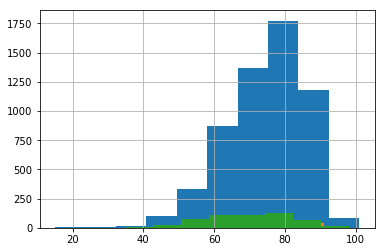

In [30]:
# PDdate - BirthYearMinus1900
ldopa_age = (pd.to_datetime(df[df['group'] == 'ldopa']['PDdate']).dt.year - 
             1900 - df[df['group'] == 'ldopa']['BirthYearMinus1900'].astype(int))
print('Ldopa Age: ')
print(ldopa_age.hist())
print(ldopa_age.describe())

rop_age = (pd.to_datetime(df[df['group'] == 'rop']['PDdate']).dt.year - 
             1900 - df[df['group'] == 'rop']['BirthYearMinus1900'].astype(int))
print('Rop Age: ')
print(rop_age.hist())
print(rop_age.describe())

combo_age = (pd.to_datetime(df[df['group'] == 'combo']['PDdate']).dt.year - 
             1900 - df[df['group'] == 'combo']['BirthYearMinus1900'].astype(int))
print(combo_age.hist())
print('Combo Age: ')
print(combo_age.describe())

In [86]:
print(df[df['group'] == 'ldopa']['FirstMed'].dt.days.describe())
print(df[df['group'] == 'rop']['FirstMed'].dt.days.describe())
print(df[df['group'] == 'combo']['FirstMed'].dt.days.describe())
print(df['FirstMed'].dt.days.describe())

count    5749.000000
mean       75.979475
std       216.346714
min         0.000000
25%         0.000000
50%         0.000000
75%        29.000000
max      2252.000000
Name: FirstMed, dtype: float64
count     285.000000
mean       94.708772
std       238.702647
min         0.000000
25%         0.000000
50%         0.000000
75%        33.000000
max      1393.000000
Name: FirstMed, dtype: float64
count     548.000000
mean       46.596715
std       137.549897
min         0.000000
25%         0.000000
50%         0.000000
75%         8.250000
max      1326.000000
Name: FirstMed, dtype: float64
count    6582.000000
mean       74.344120
std       212.125606
min         0.000000
25%         0.000000
50%         0.000000
75%        28.000000
max      2252.000000
Name: FirstMed, dtype: float64


In [31]:
df['event'] = np.where(df['PDtoDys'] > 0, 1, 0)
df['duration'] = np.where(df['PDtoDys'] > 0, df['PDtoDys'], df['PDtoNow'])
print(df['event'].value_counts())

0    5821
1     761
Name: event, dtype: int64


In [32]:
font = {'weight' : 'bold',
        'size'   : 12}
axes = {'titlesize' : 14,
        'titleweight': 'bold'}

plt.rc('font', **font)
plt.rc('axes', **axes)

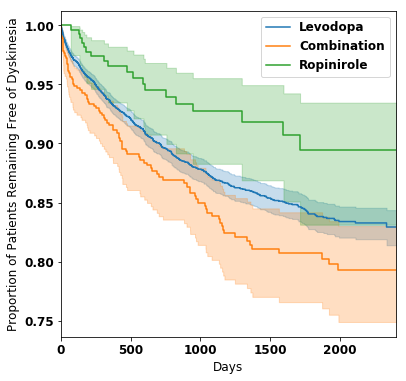

In [33]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

f = plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
f.add_subplot(ax)

kmf_ldopa = KaplanMeierFitter()
kmf_ldopa.fit(df.loc[df['group'] == 'ldopa', 'duration'], 
              event_observed=df.loc[df['group'] == 'ldopa', 'event'],
        label="Levodopa")
kmf_ldopa.plot(ax=ax)

kmf_combo = KaplanMeierFitter()
kmf_combo.fit(df.loc[df['group'] == 'combo', 'duration'], 
         event_observed=df.loc[df['group'] == 'combo', 'event'],
        label="Combination")
kmf_combo.plot(ax=ax)

kmf_rop = KaplanMeierFitter()
kmf_rop.fit(df.loc[df['group'] == 'rop', 'duration'],
        event_observed=df.loc[df['group'] == 'rop', 'event'],
        label="Ropinirole")
kmf_rop.plot(ax=ax)

plt.xlabel('Days')
plt.xticks([0, 500, 1000, 1500, 2000, 2500])
plt.xlim([0, 2400])
plt.ylabel('Proportion of Patients Remaining Free of Dyskinesia')
#add_at_risk_counts(kmf_ldopa, kmf_combo, kmf_rop, ax=ax)

In [34]:
from lifelines.statistics import logrank_test, pairwise_logrank_test

results = pairwise_logrank_test(df['duration'], df['group'], df['event'])

results['combo']['ldopa'].print_summary()
results['combo']['rop'].print_summary()
results['rop']['ldopa'].print_summary()


t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        5.0377 0.0248  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p     
       11.4695 0.0007  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        6.4688 0.0110  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


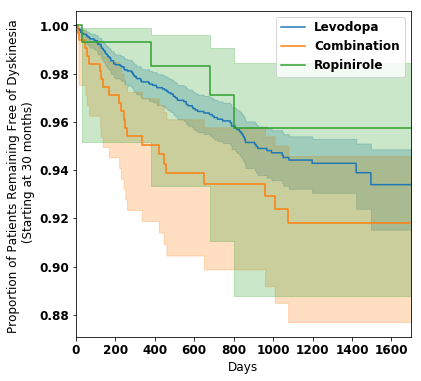

In [35]:
### Redo, but add 30 months (30.42 * 30 = 913)
kmf = KaplanMeierFitter()

f = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
f.add_subplot(ax)

thirty = pd.DataFrame()
thirty['group'] = df['group']
thirty['duration'] = df['duration'] - 913
thirty['event'] = df['event']

thirty = thirty[thirty['duration'] > 0]

# print(thirty['duration'].value_counts())

kmf.fit(thirty.loc[thirty['group'] == 'ldopa', 'duration'],
        event_observed=thirty.loc[thirty['group'] == 'ldopa', 'event'],
        label="Levodopa")
kmf.plot(ax=ax)

kmf.fit(thirty.loc[thirty['group'] == 'combo', 'duration'],
        event_observed=thirty.loc[thirty['group'] == 'combo', 'event'],
        label="Combination")
kmf.plot(ax=ax)

kmf.fit(thirty.loc[thirty['group'] == 'rop', 'duration'],
        event_observed=thirty.loc[thirty['group'] == 'rop', 'event'],
        label="Ropinirole")
kmf.plot(ax=ax)

plt.xlabel('Days')
plt.xticks()
plt.ylabel('Proportion of Patients Remaining Free of Dyskinesia \n (Starting at 30 months)')

In [87]:
results = pairwise_logrank_test(thirty['duration'], thirty['group'], thirty['event'])

results['combo']['ldopa'].print_summary()
results['combo']['rop'].print_summary()
results['rop']['ldopa'].print_summary()


t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        3.4123 0.0647  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        2.3803 0.1229
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        0.5805 0.4461
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


### this time duration from first medication instead of disease onset

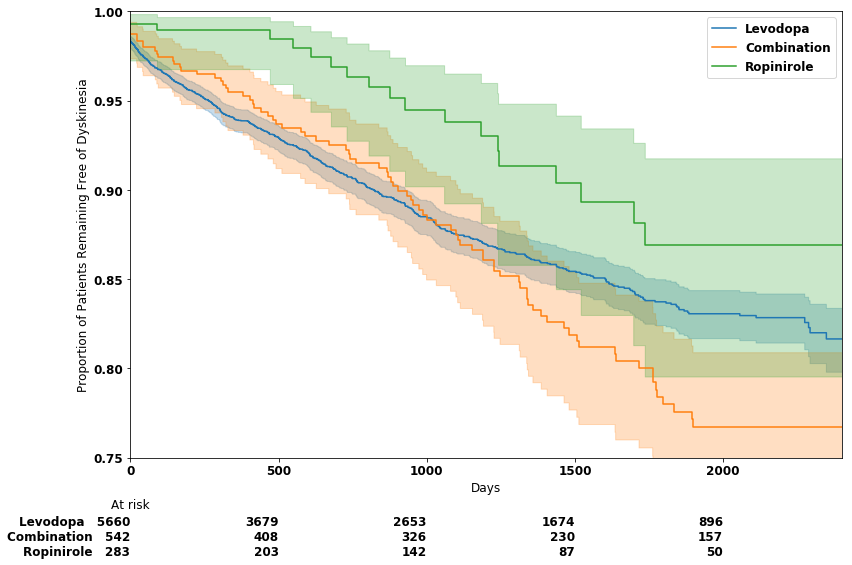

In [37]:
df['event'] = np.where(df['PDtoDys'] > 0, 1, 0)
df['duration'] = np.where(df['PDtoDys'] > 0, df['DrugToDys'].dt.days, df['PDtoNow'])

from lifelines import KaplanMeierFitter
kmf_ldopa = KaplanMeierFitter()

f = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
f.add_subplot(ax)

kmf_ldopa.fit(df.loc[df['group'] == 'ldopa', 'duration'], event_observed=df.loc[df['group'] == 'ldopa', 'event'],
        label="Levodopa")
kmf_ldopa.plot(ax=ax)

kmf_combo = KaplanMeierFitter()
kmf_combo.fit(df.loc[df['group'] == 'combo', 'duration'], event_observed=df.loc[df['group'] == 'combo', 'event'],
        label="Combination")
kmf_combo.plot(ax=ax)

kmf_rop = KaplanMeierFitter()
kmf_rop.fit(df.loc[df['group'] == 'rop', 'duration'], event_observed=df.loc[df['group'] == 'rop', 'event'],
        label="Ropinirole")
kmf_rop.plot(ax=ax)

plt.xlabel('Days')
plt.xlim([0, 2400])
plt.xticks([0, 500, 1000, 1500, 2000])
plt.ylim([0.75, 1])
plt.ylabel('Proportion of Patients Remaining Free of Dyskinesia')

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_ldopa, kmf_combo, kmf_rop, ax=ax)

In [38]:
from lifelines.statistics import logrank_test, pairwise_logrank_test

results = logrank_test(df.loc[df['group'] == 'ldopa', 'duration'],
                       df.loc[df['group'] == 'rop', 'duration'],
                       df.loc[df['group'] == 'ldopa', 'event'],
                       df.loc[df['group'] == 'rop', 'event'],
                       alpha=0.99)
results.print_summary()

results = logrank_test(df.loc[df['group'] == 'combo', 'duration'],
                       df.loc[df['group'] == 'rop', 'duration'],
                       df.loc[df['group'] == 'combo', 'event'],
                       df.loc[df['group'] == 'rop', 'event'],
                       alpha=0.99)

results.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p    
        6.9401 0.0084  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p    
        8.8259 0.0030  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [39]:
results = pairwise_logrank_test(df['duration'], df['group'], df['event'])

results['combo']['ldopa'].print_summary()
results['combo']['rop'].print_summary()
results['rop']['ldopa'].print_summary()



t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        2.7014 0.1003
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p    
        8.8259 0.0030  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p    
        6.9401 0.0084  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


### All adverse events, from Rascol et al. - 

In [40]:
icd_codes = {'Nausea': ['787.02', '787.01'], 
             'Somnolence': ['780.09'],
             'Insomnia': ['780.52', ' 780.51'],
             'Dyspepsia': ['536.8'],
             'Hallucinations': ['780.1'],
             'Headache': ['784.0', ' 339.3'], #and drug induced
             'Hypotension': ['458.9'], 
             'Ataxia': ['438.84'],
             'Anxiety': ['300.02', '292.89'], #anxiety + drug induced
             'Dystonia': ['333.79'] #dystonia
            }

In [41]:
def build_tmp_table(disease, codes):
    cursor.execute("IF OBJECT_ID('tempdb.dbo.#tmp_adv_event', 'U') IS NOT NULL DROP TABLE #tmp_adv_event;")
    
    query = ("SELECT pd.MemberNum, pd.FirstDate PDdate, dys.FirstDys DYSdate, " +  
        "datediff(d, pd.FirstDate, dys.FirstDys) as PDtoDys, e.LastCancel, " + 
        "IIF(e.LastCancel < Cast('02/29/2016' as datetime), " + 
        "datediff(d, pd.FirstDate, e.LastCancel), " + 
        "datediff(d, pd.FirstDate, Cast('02/29/2016' as datetime))) as PDtoNow, " + 
        "ldopa.FirstDate as FirstLdopa, pram.FirstDate as FirstPram, " +
        "rop.FirstDate as FirstRop, rot.FirstDate as FirstRot, " + 
        "ldopa.ldopa_claims, pram.pram_claims, rop.rop_claims, rot.rot_claims, " + 
        "member.BirthYearMinus1900, member.Gender " + 
        "INTO #tmp_adv_event FROM (" + 
        "SELECT MemberNum, FirstDate from gmw3.dbo.DistinctDiagnosis " + 
        "WHERE DiagnosisCode = '332.0' AND " + 
        "PresentOnAdmission is NULL AND " + 
        "FirstDate > Cast('12/31/2008' as datetime)) pd " + 
        "LEFT JOIN (SELECT MemberNum, MIN(FirstDate) FirstDys " + 
        "FROM gmw3.dbo.DistinctDiagnosis " + 
        "WHERE DiagnosisCode IN ('" + codes + "') " + 
        "AND PresentOnAdmission is NULL GROUP BY MemberNum ) dys " + 
        "ON pd.MemberNum = dys.MemberNum " +
        "LEFT JOIN (SELECT MemberNum, MAX(CancelDate) as LastCancel " + 
        "FROM bkb12.dbo.pd_Enrollment " + 
        "WHERE CancelDate is not Null AND MedicalIndicator = 'Y' " +
        "AND DrugIndicator = 'Y' GROUP BY MemberNum) e " + 
        "ON pd.MemberNum = e.MemberNum " + 
        "LEFT JOIN (SELECT MemberNum, SUM(NumberOfClaims) as ldopa_claims, MIN(FirstDispenseDate) as FirstDate " +
        "FROM gmw3.dbo.DistinctMedication dm " +
        "WHERE NationalDrugCode IN " +
        "(SELECT NationalDrugCode FROM bkb12.dbo.dc_ldopa) " +
        "GROUP BY MemberNum ) ldopa ON pd.MemberNum = ldopa.MemberNum " + 
        "LEFT JOIN ( SELECT MemberNum, " + 
        "SUM(NumberOfClaims) as pram_claims, MIN(FirstDispenseDate) as FirstDate " +
        "FROM gmw3.dbo.DistinctMedication dm " + 
        "WHERE NationalDrugCode IN " + 
        "(SELECT NationalDrugCode FROM bkb12.dbo.dc_pramipexole) " + 
        "GROUP BY MemberNum ) pram ON pd.MemberNum = pram.MemberNum " + 
        "LEFT JOIN (SELECT MemberNum, " + 
        "SUM(NumberOfClaims) as rop_claims, MIN(FirstDispenseDate) as FirstDate " + 
        "FROM gmw3.dbo.DistinctMedication dm " + 
        "WHERE NationalDrugCode IN " + 
        "(SELECT NationalDrugCode FROM bkb12.dbo.dc_ropinirole) " + 
        "GROUP BY MemberNum ) rop ON pd.MemberNum = rop.MemberNum " +
        "LEFT JOIN (SELECT MemberNum, " + 
        "SUM(NumberOfClaims) as rot_claims, MIN(FirstDispenseDate) as FirstDate " +
        "FROM gmw3.dbo.DistinctMedication dm " +
        "WHERE NationalDrugCode IN " + 
        "(SELECT NationalDrugCode FROM bkb12.dbo.dc_rotigotine) " +
        "GROUP BY MemberNum ) rot ON pd.MemberNum = rot.MemberNum " +
        "LEFT JOIN gmw3.dbo.Member as member " +
        "ON member.MemberNum = pd.MemberNum " +
        "WHERE datediff(d, pd.FirstDate, dys.FirstDys) > 0 " + 
        "OR dys.FirstDys is Null;")
    
    print(query)
    cursor.execute(query)
   

In [42]:
i = 0 
for disease, codes in icd_codes.items():
    print(disease)
    codeString = "','".join(codes)
    print(type(codeString), codeString)
    
    build_tmp_table(disease, codeString)
    
    query = ("SELECT * FROM #tmp_adv_event")
    print(query)
    res = pd.read_sql_query(query, cn)
    res.fillna(0, inplace=True)

    print(res.shape)
    print(res.head())

    res['ldopa_rop_claims'] = res['ldopa_claims'] + res['rop_claims']
    res.to_csv("/home/bkb12/data/pd/res" + disease + ".csv")

Nausea
<class 'str'> 787.02','787.01
SELECT pd.MemberNum, pd.FirstDate PDdate, dys.FirstDys DYSdate, datediff(d, pd.FirstDate, dys.FirstDys) as PDtoDys, e.LastCancel, IIF(e.LastCancel < Cast('02/29/2016' as datetime), datediff(d, pd.FirstDate, e.LastCancel), datediff(d, pd.FirstDate, Cast('02/29/2016' as datetime))) as PDtoNow, ldopa.FirstDate as FirstLdopa, pram.FirstDate as FirstPram, rop.FirstDate as FirstRop, rot.FirstDate as FirstRot, ldopa.ldopa_claims, pram.pram_claims, rop.rop_claims, rot.rot_claims, member.BirthYearMinus1900, member.Gender INTO #tmp_adv_event FROM (SELECT MemberNum, FirstDate from gmw3.dbo.DistinctDiagnosis WHERE DiagnosisCode = '332.0' AND PresentOnAdmission is NULL AND FirstDate > Cast('12/31/2008' as datetime)) pd LEFT JOIN (SELECT MemberNum, MIN(FirstDate) FirstDys FROM gmw3.dbo.DistinctDiagnosis WHERE DiagnosisCode IN ('787.02','787.01') AND PresentOnAdmission is NULL GROUP BY MemberNum ) dys ON pd.MemberNum = dys.MemberNum LEFT JOIN (SELECT MemberNum, MA

SELECT * FROM #tmp_adv_event
(59316, 16)
     MemberNum      PDdate     DYSdate  PDtoDys  LastCancel  PDtoNow  \
0  13474735025  2011-12-08           0      0.0  9999-12-31     1544   
1  52657166125  2009-07-29  2009-11-30    124.0           0     2406   
2  57261313325  2013-08-01           0      0.0           0      942   
3  65100032325  2011-04-28           0      0.0  9999-12-31     1768   
4  69188368325  2009-01-30           0      0.0           0     2586   

   FirstLdopa FirstPram FirstRop FirstRot  ldopa_claims  pram_claims  \
0  2008-10-23         0        0        0           2.0          0.0   
1           0         0        0        0           0.0          0.0   
2           0         0        0        0           0.0          0.0   
3           0         0        0        0           0.0          0.0   
4           0         0        0        0           0.0          0.0   

   rop_claims  rot_claims  BirthYearMinus1900 Gender  
0         0.0         0.0             

Headache
<class 'str'> 784.0',' 339.3
SELECT pd.MemberNum, pd.FirstDate PDdate, dys.FirstDys DYSdate, datediff(d, pd.FirstDate, dys.FirstDys) as PDtoDys, e.LastCancel, IIF(e.LastCancel < Cast('02/29/2016' as datetime), datediff(d, pd.FirstDate, e.LastCancel), datediff(d, pd.FirstDate, Cast('02/29/2016' as datetime))) as PDtoNow, ldopa.FirstDate as FirstLdopa, pram.FirstDate as FirstPram, rop.FirstDate as FirstRop, rot.FirstDate as FirstRot, ldopa.ldopa_claims, pram.pram_claims, rop.rop_claims, rot.rot_claims, member.BirthYearMinus1900, member.Gender INTO #tmp_adv_event FROM (SELECT MemberNum, FirstDate from gmw3.dbo.DistinctDiagnosis WHERE DiagnosisCode = '332.0' AND PresentOnAdmission is NULL AND FirstDate > Cast('12/31/2008' as datetime)) pd LEFT JOIN (SELECT MemberNum, MIN(FirstDate) FirstDys FROM gmw3.dbo.DistinctDiagnosis WHERE DiagnosisCode IN ('784.0',' 339.3') AND PresentOnAdmission is NULL GROUP BY MemberNum ) dys ON pd.MemberNum = dys.MemberNum LEFT JOIN (SELECT MemberNum, MA

SELECT * FROM #tmp_adv_event
(63316, 16)
     MemberNum      PDdate DYSdate  PDtoDys  LastCancel  PDtoNow  FirstLdopa  \
0   6636655025  2010-03-24       0      0.0  2011-05-24      426  2010-03-05   
1   6781668525  2014-10-30       0      0.0           0      487           0   
2  12752174525  2012-02-29       0      0.0  9999-12-31     1461           0   
3  43313420825  2010-08-12       0      0.0  9999-12-31     2027           0   
4  66276972725  2009-08-25       0      0.0           0     2379           0   

    FirstPram FirstRop FirstRot  ldopa_claims  pram_claims  rop_claims  \
0           0        0        0          15.0          0.0         0.0   
1           0        0        0           0.0          0.0         0.0   
2           0        0        0           0.0          0.0         0.0   
3  2010-09-07        0        0           0.0         89.0         0.0   
4           0        0        0           0.0          0.0         0.0   

   rot_claims  BirthYearMinus1900

/home/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


ldopa    12069
combo     1342
rop        436
Name: group, dtype: int64


/home/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

0    12732
1     1115
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        3.3022 0.0692  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        2.1489 0.1427
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        6.2383 0.0125  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


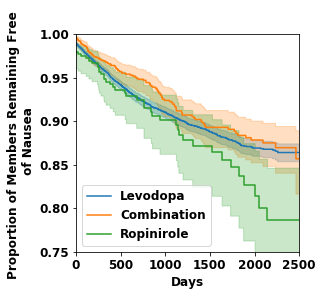

ldopa    12294
combo     1379
rop        461
Name: group, dtype: int64
0    12836
1     1298
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        5.7007 0.0170  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        2.5652 0.1092
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        2.0346 0.1538
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


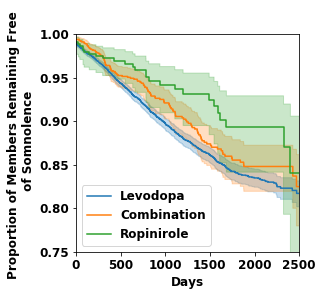

ldopa    12219
combo     1341
rop        460
Name: group, dtype: int64
0    12988
1     1032
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        0.0231 0.8793
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p    
       10.1300 0.0015  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        2.6538 0.1033
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


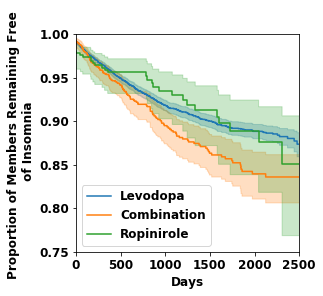

ldopa    12654
combo     1388
rop        493
Name: group, dtype: int64
0    14284
1      251
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        3.7629 0.0524  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        3.0891 0.0788  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        0.5116 0.4744
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


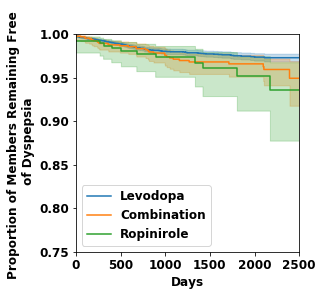

ldopa    12759
combo     1406
rop        496
Name: group, dtype: int64
0    14217
1      444
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        1.1855 0.2762
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        2.6780 0.1017
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        2.8110 0.0936  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


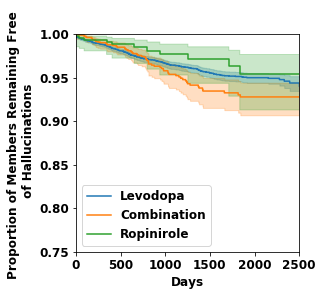

ldopa    11655
combo     1305
rop        426
Name: group, dtype: int64
0    12035
1     1351
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        0.2011 0.6538
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        5.1444 0.0233  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        0.4573 0.4989
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


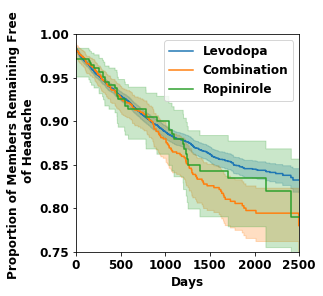

ldopa    12380
combo     1381
rop        472
Name: group, dtype: int64
0    13046
1     1187
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        1.1504 0.2835
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        0.9766 0.3230
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        0.1857 0.6665
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


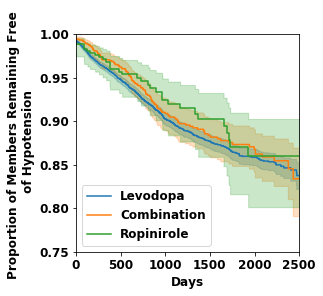

ldopa    12737
combo     1405
rop        500
Name: group, dtype: int64
0    14476
1      166
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        0.1696 0.6805
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        0.3003 0.5837
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        0.0023 0.9620
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


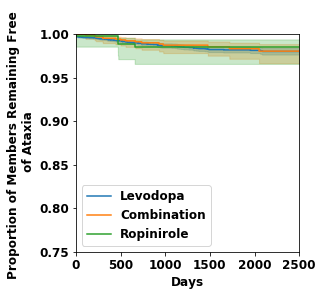

ldopa    12533
combo     1375
rop        486
Name: group, dtype: int64
0    13922
1      472
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        3.9174 0.0478  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p   
        0.1832 0.6686
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        2.0616 0.1511
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


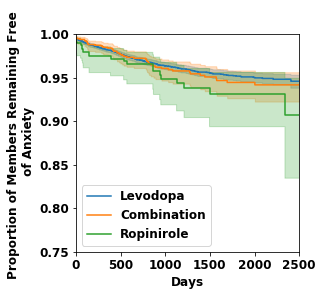

ldopa    12818
combo     1400
rop        503
Name: group, dtype: int64
0    14593
1      128
Name: event, dtype: int64

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=ldopa vs. rop

test_statistic      p   
        0.0024 0.9607
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. ldopa

test_statistic      p    
        7.3589 0.0067  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

t_0=-1, alpha=0.9833333333333333, null_distribution=chi squared, df=1, use_bonferroni=True, test_name=combo vs. rop

test_statistic      p   
        1.4662 0.2259
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


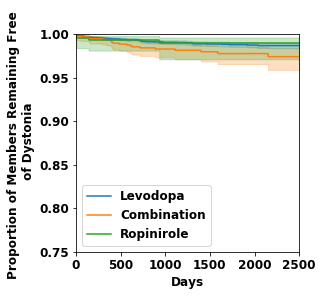

In [89]:
# from first medication
from lifelines import KaplanMeierFitter

for disease, codes in icd_codes.items():
    res = pd.read_csv("/home/bkb12/data/pd/res" + disease + ".csv")
    df = res[res['ldopa_rop_claims'] > 0]
    
    df.loc[((df['ldopa_claims'] > 0) & (df['rop_claims'] == 0)), 'group'] = 'ldopa'
    df.loc[((df['ldopa_claims'] == 0) & (df['rop_claims'] > 0)), 'group'] = 'rop'
    df.loc[((df['ldopa_claims'] > 0) & (df['rop_claims'] > 0)), 'group'] = 'combo'

    print(df['group'].value_counts())
    
    df['FirstLdopa'] = pd.to_datetime(df['FirstLdopa'], errors='coerce')
    df['FirstPram'] = pd.to_datetime(df['FirstPram'], errors='coerce')
    df['FirstRop'] = pd.to_datetime(df['FirstRop'], errors='coerce')
    df['FirstRot'] = pd.to_datetime(df['FirstRot'], errors='coerce')

    df['FirstLdopa'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
    df['FirstPram'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
    df['FirstRop'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
    df['FirstRot'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
    
    df['DYSdate'] = pd.to_datetime(df['DYSdate'], errors='coerce')
    df['DYSdate'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
    
    df['DrugToDys'] = (df['DYSdate'] -
                       df[['FirstLdopa','FirstPram', 'FirstRop', 'FirstRot']].min(axis=1))
    df['event'] = np.where(df['PDtoDys'] > 0, 1, 0)
    df['duration'] = np.where(df['PDtoDys'] > 0, df['DrugToDys'].dt.days, df['PDtoNow'])
    print(df['event'].value_counts())
    
    kmf = KaplanMeierFitter()

    f = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    f.add_subplot(ax)

    kmf.fit(df.loc[df['group'] == 'ldopa', 'duration'], event_observed=df.loc[df['group'] == 'ldopa', 'event'],
            label="Levodopa")
    kmf.plot(ax=ax)

    kmf.fit(df.loc[df['group'] == 'combo', 'duration'], event_observed=df.loc[df['group'] == 'combo', 'event'],
            label="Combination")
    kmf.plot(ax=ax)

    kmf.fit(df.loc[df['group'] == 'rop', 'duration'], event_observed=df.loc[df['group'] == 'rop', 'event'],
            label="Ropinirole")
    kmf.plot(ax=ax)
    
    results = pairwise_logrank_test(df['duration'], df['group'], df['event'])

    results['rop']['ldopa'].print_summary()
    results['combo']['ldopa'].print_summary()
    results['combo']['rop'].print_summary()
    

    plt.xlabel('Days', fontweight='bold')
    plt.ylabel('Proportion of Members Remaining Free \n of ' + disease, fontweight='bold')
    plt.ylim(0.75, 1)
    plt.xlim(0, 2500)
    f.savefig('./plots/med_' + disease + '.png')
    plt.show()

In [ ]:
# from disease onset
from lifelines import KaplanMeierFitter

for disease, codes in icd_codes.items():
    res = pd.read_csv("/home/bkb12/data/pd/res" + disease + ".csv")
    df = res[res['ldopa_rop_claims'] > 0]
    
    df.loc[((df['ldopa_claims'] > 0) & (df['rop_claims'] == 0)), 'group'] = 'ldopa'
    df.loc[((df['ldopa_claims'] == 0) & (df['rop_claims'] > 0)), 'group'] = 'rop'
    df.loc[((df['ldopa_claims'] > 0) & (df['rop_claims'] > 0)), 'group'] = 'combo'

    print(df['group'].value_counts())
    
    df['event'] = np.where(df['PDtoDys'] > 0, 1, 0)
    df['duration'] = np.where(df['PDtoDys'] > 0, df['PDtoDys'], df['PDtoNow'])
    print(df['event'].value_counts())
    
    kmf = KaplanMeierFitter()

    f = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    f.add_subplot(ax)

    kmf.fit(df.loc[df['group'] == 'ldopa', 'duration'], event_observed=df.loc[df['group'] == 'ldopa', 'event'],
            label="Levodopa")
    kmf.plot(ax=ax)

    kmf.fit(df.loc[df['group'] == 'combo', 'duration'], event_observed=df.loc[df['group'] == 'combo', 'event'],
            label="Combination")
    kmf.plot(ax=ax)

    kmf.fit(df.loc[df['group'] == 'rop', 'duration'], event_observed=df.loc[df['group'] == 'rop', 'event'],
            label="Ropinirole")
    kmf.plot(ax=ax)

    plt.xlabel('Days', fontweight='bold')
    plt.ylabel('Proportion of Patients Remaining Free \n of ' + disease, fontweight='bold')
    plt.ylim(0.75, 1)
    f.savefig('./plots/' + disease + '.png')

### Let's check without medication requirement

In [ ]:
query = ("SELECT * FROM bkb12.dbo.pd_dysk")
print(query)
df2 = pd.read_sql_query(query, cn)
print(df2.shape)

In [ ]:
df2.loc[((df2['ldopa_claims'] > 0) & (df2['rop_claims'] == 0)), 'group'] = 'ldopa'
df2.loc[((df2['ldopa_claims'] == 0) & (df2['rop_claims'] > 0)), 'group'] = 'rop'
df2.loc[((df2['ldopa_claims'] > 0) & (df2['rop_claims'] > 0)), 'group'] = 'combo'

print(df2['group'].value_counts())

# df.loc[((df['ldopa_claims'] == 0) & (df['rop_claims'] == 0)), 'group'] = 'other'
# df.loc[((df['ldopa_claims'] > 0) & (df['rop_claims'] > 0)), 'group'] = 'combo'
# df.loc[((df['ldopa_claims'] > 0) & (df['rop_claims'] == 0)), 'group'] = 'ldopa'
# df.loc[((df['ldopa_claims'] == 0) & (df['rop_claims'] > 0)), 'group'] = 'rop'


# print(df['group'].value_counts())

In [ ]:
df['event'] = np.where(df['PDtoDys'] > 0, 1, 0)
df['duration'] = np.where(df['PDtoDys'] > 0, df['PDtoDys'], df['PDtoNow'])
print(df['event'].value_counts())

In [ ]:
df['FirstLdopa'] = pd.to_datetime(df['FirstLdopa'], errors='coerce')
df['FirstPram'] = pd.to_datetime(df['FirstPram'], errors='coerce')
df['FirstRop'] = pd.to_datetime(df['FirstRop'], errors='coerce')
df['FirstRot'] = pd.to_datetime(df['FirstRot'], errors='coerce')

df['FirstLdopa'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
df['FirstPram'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
df['FirstRop'].fillna(pd.to_datetime('12/31/2020'), inplace=True)
df['FirstRot'].fillna(pd.to_datetime('12/31/2020'), inplace=True)

df['DYSdate'] = pd.to_datetime(df['DYSdate'], errors='coerce')
df['DYSdate'].fillna(pd.to_datetime('12/31/2020'), inplace=True)

df['DrugToDys'] = (df['DYSdate'] -
                   df[['FirstLdopa','FirstPram', 'FirstRop', 'FirstRot']].min(axis=1))
print(df.head())